In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import email
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import string

In [2]:
# This cell imports all emails into a dictionary where the keys are given by the file path to that email.
# Using a dictionary was helpful for me to figure out where errors were coming from, but if I were to do
# this assignment over now, I might save some time bypassing loading the data into various structures.

data_dir = './Alaffia_Take_Home_Exercise_Data/'

all_emails = {}

for root, dirs, files in os.walk(data_dir):
     for file in files:
        if file != '.DS_Store':
            with open(os.path.join(root, file), "r", encoding="ISO-8859-1") as email_info:
                text = email_info.read()
                full_path = root + "/" + file
                all_emails[full_path] = text

            

In [3]:
def clean_email(raw_message):
    '''This function takes in an email, extracts the relevant information: sender, recipient, and body and 
    returns a dictionary of lists (one for each subset of information)'''
    
    email_dict = {}
    
    #Extract body of email and add to dictionary
    b = email.message_from_string(raw_message)
    body = []
    if b.is_multipart():
        for payload in b.get_payload():
            body.append(payload.get_payload())
    else:
        body = b.get_payload().split('\n')
    
    try:
        body = [elem for elem in body if elem.strip()] 
    except:
        new_body = []
        for elem in body:
            if isinstance(elem, str):
                new_body.append(elem)
            elif isinstance(elem, list):
                for elem in elem:
                    new_body.append(elem.get_payload())
                
    
    # Extract who email is from and to and add to dictionary. I lumped direct emails and forwarded
    # emails into the same category.
    keys_to_extract = ['from', 'to', 'x-to', 'in-reply-to']
    split_raw = raw_message.split('\n')
    
    for line in split_raw:
        if ':' in line:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                if key == 'x-to' or key == 'in-reply-to':
                    key = 'to'
                email_dict[key] = val
                email_dict['body'] = ' '.join(body)

    return email_dict


In [4]:
nltk.download('words')
common_words = set(nltk.corpus.words.words())

def filter_words(text):
    '''This function filters out all non-English words'''
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in common_words)
    return text


[nltk_data] Downloading package words to /Users/sgilbert/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [5]:
# This cell cleans all of the email data. A small percentage of the data (~0.3%) failed cleaning
# for various reasons, so I didn't include those emails. In a real-world scenario, I would work on
# making sure all data are included (don't want to lose anything valuable!), but for this assignment
# I felt it was an appropriate sacrifice to get a working program within the time constraints.

num_failed = 0

email_features = {
    'body': [],
    'sender': [],
    'recipient': []
}

for key in all_emails.keys():
    try:
        cleaned_email = clean_email(all_emails[key])
        cleaned_email['body'] = filter_words(cleaned_email['body'])
        email_features['recipient'].append(cleaned_email['to'])
        email_features['body'].append(cleaned_email['body'])
        email_features['sender'].append(cleaned_email['from'])
    except:
        num_failed += 1


print(num_failed)

email_data = pd.DataFrame(email_features) # Creates Pandas Data Frame for easy handling of data
    

35


In [6]:
def get_data_matrix_and_features(data, max_df=0.3, min_df=2):
    '''This function takes the email data and converts it to a term frequency–inverse document frequency
    matrix. The score given by this metric indicates how important a word is to the body from which it is pulled'''
    
    vect = TfidfVectorizer(analyzer='word', stop_words=ENGLISH_STOP_WORDS, max_df=max_df, min_df=min_df)
    body_data_matrix = vect.fit_transform(data)
    features = vect.get_feature_names()
    
    return body_data_matrix, features

body_data_matrix, features = get_data_matrix_and_features(email_data.body)

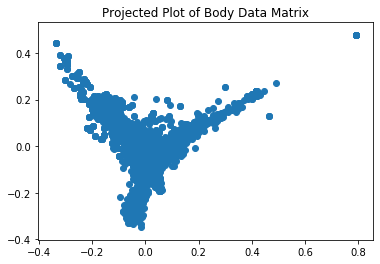

In [7]:
# A plot made by performing principal component analysis on the data matrix for visualization.
# The plot gives an idea of how the data cluster. It seems like it can be approximately separated into 3 groups 

dense_body_matrix = body_data_matrix.todense()
coordinates = PCA(n_components=2).fit_transform(dense_body_matrix)
plt.scatter(coordinates[:, 0], coordinates[:, 1])
plt.title("Projected Plot of Body Data Matrix")
plt.show()

In [8]:
def most_important_words(data, features, row_num, num_words):
    '''Gets top num_words most important words in a given email body
    where row_num designates the email index in the email_data Data Frame
    '''
    
    row = np.squeeze(data[row_num].toarray())
    indices = np.argsort(row)[::-1][:num_words]
    most_important_words = [(features[i], row[i]) for i in indices]
    return pd.DataFrame(most_important_words, columns=['word', 'score'])

def tot_most_important_words(data, features, min_tfidf=0.15, num_words=25):
    data = data.toarray()
    data[data < min_tfidf] = 0 # Zeroes out tfidf values below the minimum threshold
    
    means = np.mean(data, axis=0)
    indices = np.argsort(means)[::-1][:num_words]
    most_important_words = [(features[i], means[i]) for i in indices]
    
    return pd.DataFrame(most_important_words, columns=['word', 'score'])

# These are the most important words across the entire email corpus
print(tot_most_important_words(body_data_matrix, features))

           word     score
0          jeff  0.019433
1          date  0.019070
2         yahoo  0.008608
3      attached  0.008342
4         table  0.008314
5       message  0.008064
6          beta  0.007950
7        report  0.007938
8      skilling  0.007612
9         image  0.006940
10       energy  0.006610
11       thanks  0.006393
12         font  0.006074
13         memo  0.005975
14      meeting  0.005731
15         mark  0.005536
16          use  0.005146
17         file  0.005063
18         list  0.004968
19  information  0.004919
20   conference  0.004863
21        great  0.004769
22     business  0.004568
23         mail  0.004460
24       center  0.004319


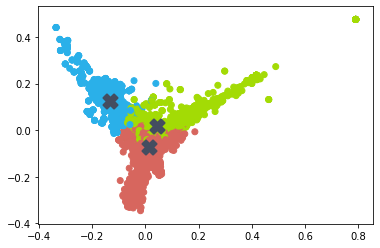

In [62]:
# This cell performs a K-Means clustering to allow the algorithm to learn the 3 groups of emails

num_clusters = 3

clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(body_data_matrix)

# Converts to matrix for easy PCA
dense_body_data_matrix = body_data_matrix.todense()
pca = PCA(n_components=2).fit(dense_body_data_matrix)
coordinates = pca.transform(dense_body_data_matrix)

# Plot clusters and centroids
label_colors = ["#2AB0E9", "#D7665E", "#A3DB05"]
colors = [label_colors[i] for i in labels]
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=colors)
centroids = clf.cluster_centers_
centroid_coordinates = pca.transform(centroids)
plt.scatter(centroid_coordinates[:, 0], centroid_coordinates[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.title
plt.show()

In [70]:
# This cell splits the email data up into the groups determined by the K-Means algorithm
# and analyzes the most important words in each group

group1 = {'body': []}
group2 = {'body': []}
group3 = {'body': []}

for index, label in enumerate(labels):
    if label == 0:
        group1['body'].append(email_data.body[index])
    elif label == 1:
        group2['body'].append(email_data.body[index])
    else:
        group3['body'].append(email_data.body[index])

group1 = pd.DataFrame(group1)
group2 = pd.DataFrame(group2)
group3 = pd.DataFrame(group3)

body_data_matrix1, features1 = get_data_matrix_and_features(group1.body)
body_data_matrix2, features2 = get_data_matrix_and_features(group2.body)
body_data_matrix3, features3 = get_data_matrix_and_features(group3.body)

print("group 1: ", "\n", tot_most_important_words(body_data_matrix1, features1, num_words=15), "\n")
print("group 2: ", "\n", tot_most_important_words(body_data_matrix2, features2, num_words=15), "\n")
print("group 3: ", "\n", tot_most_important_words(body_data_matrix3, features3, num_words=15), "\n")

group 1:  
            word     score
0       message  0.027322
1         great  0.016757
2          goal  0.014086
3       company  0.013287
4    conference  0.012591
5          mark  0.012421
6          park  0.012045
7         board  0.012030
8        number  0.011516
9        letter  0.011485
10  information  0.011092
11         just  0.010661
12        chief  0.010634
13      meeting  0.010589
14         send  0.010285 

group 2:  
          word     score
0       table  0.017836
1        beta  0.016714
2       yahoo  0.015708
3        font  0.012083
4         use  0.008480
5        mail  0.007958
6        file  0.007754
7   signature  0.007752
8     message  0.007146
9     package  0.006848
10       body  0.006367
11       free  0.006203
12    version  0.005901
13        hat  0.005788
14       line  0.005616 

group 3:  
          word     score
0        date  0.040559
1    attached  0.015186
2      report  0.014606
3       image  0.012527
4      energy  0.011872
5        memo  0